userName is zhengf_pw.x

len is 2067

read sweep line:#####

line size is 0.629805

line size is 0.629805

r sweepline size is 20

write sweep line:#####

line size is 3.852955

line size is 3.852955

w sweepline size is 25

read write sweep line:#####

line size is 4.363909

line size is 4.363909

wr sweep line size is 44

r_size:0.629805, w_size:3.852955, wr_size:4.363909

len of wr_sweep is 4

number of points on the sweepline:44, timing percent:0.905642, max_files:5

filename:/global/cscratch1/sd/zhengf/Cu111/COH_OH_2H2O/H-path/1-4/5.1/PtCO_vacuum.wfc131, time:3.804846, rank:130, nprocs:1, stripe_size:1.000000, read_size:385324800.000000, write_size:195231232.000000, total_size:580556032.000000, max_bytes_written:5137663.000000, max_bytes_read:5137663.000000, small io:0.000000

key:small_io_ratio, value:0.0, inteval:3.804846, total:4.603391

filename:/global/cscratch1/sd/zhengf/Cu111/COH_OH_2H2O/H-path/1-4/5.1/PtCO_vacuum.wfc239, time:0.499166, rank:238, nprocs:1, stripe_size:1.000

<Figure size 432x288 with 0 Axes>

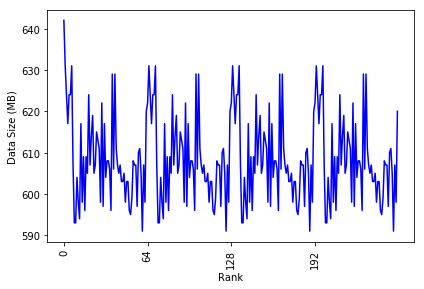

In [11]:

import matplotlib.pyplot as plt
import random
import numpy as np
import string
import re
import time
import string
import pickle
import ntpath


max_files = 5
faster_bw = 1
adjust = 1
reshuffle = 1
dbg = False

ost_lst = [dict() for x in range(248)]
class Points(object):
    def __init__(self, start = 0, end = 0):
        self.start = start
        self.end = end

    
class LPoints(object):
    def __init__(self, rank = -1, id_ = -1, filename = "", start = 0, end = 0, interval = 0, data_size = 0):
        self.start = start
        self.end = end
        self.id = id
        self.rank = rank
        self.filename = filename
        self.interval = interval
        self.data_size = data_size

class TPoints(object):
    def __init__(self, id = -1, time = -1, interval = -1, cur_type = -1):
        self.id = id
        self.time = time
        self.interval = interval
        self.type = cur_type

def long(val):
    return int(val)

def parse_darshan_username(s):
    DARSHAN_FILE_PATTERN = '(\S+)_id(\d+)_\d+-\d+-(\S+).darshan'
    darshan_file_pattern = re.compile(DARSHAN_FILE_PATTERN)
    match = darshan_file_pattern.match(s)
    if match is not None:
        return match.group(1)
    else:
        return "0"

def parse_darshan_jobid(s):
    DARSHAN_FILE_PATTERN = '(\S+)_id(\d+)_\d+-\d+-(\S+).darshan'
    darshan_file_pattern = re.compile(DARSHAN_FILE_PATTERN)
    match = darshan_file_pattern.match(s)
    if match is not None:
        return match.group(2)
    else:
        return "0"        

def adjust_timing(tmp_arr, rank):
    prev_point = tmp_arr[0]
    for i in range(1, len(tmp_arr)):
        cur_point = tmp_arr[i]
      #  print ("cur_poinst start:%lf, end:%lf, interval:%lf\n"%(cur_point.start,cur_point.end,cur_point.interval))
        if cur_point.start < prev_point.end:
            cur_point.start = prev_point.end
            cur_point.end = cur_point.start + cur_point.interval
        prev_point = cur_point
            
def reshuffle_arr(r_rank_arr):
    rank_dict = {}
    for record in r_rank_arr:
        if rank_dict.get(record.rank, -1) == -1:
            rank_dict[record.rank] = []
        rank_dict[record.rank].append(record)
    for key,value in rank_dict.items():
        cur_list = value
        cur_list.sort(key=lambda x: (x.start, -(x.end - x.start)))
        if dbg == 1:
            if key == 0:
                print ("rank 0 timing before adjustment:")
                for record in cur_list:
                    print ("start:%lf, end:%lf, interval:%lf\n"%(record.start, record.end, record.interval))
        adjust_timing(cur_list, key)
        if dbg == 1:
            if key == 0:
                print ("rank 0 timing after adjustment:")
                for record in cur_list:
                    print ("start:%lf, end:%lf, interval:%lf\n"%(record.start, record.end, record.interval))
    
    result_arr = []
    for key,value in rank_dict.items():
        cur_list = value
        for num in cur_list:
            result_arr.append(num)
    return result_arr

# extract per-rank, per-file and total counters from Darshan log
#io_rank_arr: store the per-rank counters (io_rank_arr[rank]["FileName"]["POSIX_BYTES_WRITTEN"])
#glb_dict: store the global counters (e.g. glb_dict["total_POSIX_BYTES_WRITTEN"])
#per_file_dict: store the per-file counters (e.g. per_file_dict["FileName"]["nprocs"])    
def extract_proc_info(fname):
    LOG_PATTERN = '(\S+)\t([+-]?\d+(?:\.\d+)?)\t([+-]?\d+(?:\.\d+)?)\t(\S+)\t([+-]?\d+(?:\.\d+)?)\t(\S+)\t(\S+)\t(\S+)'
    darshan_log_pattern = re.compile(LOG_PATTERN)
    
    NPROCS_PATTERN = '(#\s+nprocs:\s+)(\d+)'
    nprocs_pattern = re.compile(NPROCS_PATTERN)
    suffix = fname.rsplit('/')[-1]
    
    PERF_PATTERN = '(#\s+)(\S+):\s+(\d+\.\d+)'
    darshan_perf_pattern = re.compile(PERF_PATTERN)
    
    PER_FILE_PATTERN = '([^#]+)(\s+)(\S+)(\s+)(\d+)(\s+(\S+)){12,}'
    darshan_per_file_pattern = re.compile(PER_FILE_PATTERN)
 
    DARSHAN_FILE_PATTERN = '(\S+)_id(\d+)_\d+-\d+-(\S+).darshan'
    darshan_file_pattern = re.compile(DARSHAN_FILE_PATTERN)
  
    HEADER_PATTERN = '(#\s+)(\S+):(\s+)(\d+)'
    header_pattern = re.compile(HEADER_PATTERN)
    
    KEY_VALUE_PATTERN = '(\S+):(\s+)([+-]?\d+(?:\.\d+)?)'
    kv_pattern = re.compile(KEY_VALUE_PATTERN)

    jobID = parse_darshan_jobid(suffix)
    
    userName = parse_darshan_username(suffix)
    print ("userName is %s\n"%userName)

    rank_size = {}
    w_rank_arr = []
    r_rank_arr = []
    wr_rank_arr = []
    io_rank_arr = {}
    usedOST = []
    
    glb_dict = {}
    glb_dict["JobID"] = jobID
    glb_dict["FileName"] = fname
    glb_dict["UserName"] = userName
    
    per_file_dict = {}

    nprocs = -1
    counter = 0
    first_read_time = -1;
    second_read_time = -1;
    prev_rank = -1
    with open(fname) as infile:
        for line in infile:
            if line.find("total_MPIIO") != -1:
                key_prefix="MPIIO_"
            if line.find("total_STDIO") != -1:
                key_prefix="STDIO_"
            if line.find("total_POSIX") != -1:
                key_prefix="POSIX_"
                
            header_match = header_pattern.match(line)
            if header_match is not None:
                counter_key = header_match.group(2)
                counter_val = header_match.group(4)
                if counter_key == "start_time" or counter_key == "end_time":
                    glb_dict[counter_key] = counter_val
                    if dbg == True:
                        print ("header key:%s, header value:%s\n"%(counter_key, counter_val))
                    continue

            kv_match = kv_pattern.match(line)
            if kv_match is not None:
                counter_key = kv_match.group(1)
                counter_val = kv_match.group(3)
                glb_dict[counter_key] = counter_val
                if dbg == True:
                    print ("counter_key:%s, counter_val:%s\n"%(counter_key, counter_val))
                continue
                    
            nprocs_match = nprocs_pattern.match(line)
            if nprocs_match is not None:
                nprocs = int(nprocs_match.group(2))
                glb_dict["nprocs"] = str(nprocs)
                if dbg == True:
                    print ("nprocs is %s\n"%nprocs)
                continue
                
            log_pattern_match = darshan_log_pattern.match(line)
            if log_pattern_match is not None:
                cur_rank = int(log_pattern_match.group(2))
                file_name = log_pattern_match.group(6).strip()
                if file_name == "<STDOUT>" or file_name == "<STDIN>":
                    continue
                per_file_key = log_pattern_match.group(4).strip()
                per_file_val = log_pattern_match.group(5).strip()
                if per_file_key == "POSIX_BYTES_READ":
                    read_size = long(per_file_val)
                    counter += 1
                    if dbg == True:
                        print ("filename:%s, file bytes read:%ld\n"%(file_name, read_size))
                if per_file_key == "POSIX_BYTES_WRITTEN":
                    write_size = long(per_file_val)
                    counter += 1
                    if dbg == True:
                        print ("filename:%s, file bytes written:%ld\n"%(file_name, write_size))
                if per_file_key == "POSIX_F_READ_START_TIMESTAMP":
                    cur_read_start = float(per_file_val)
                    counter += 1
                if per_file_key == "POSIX_F_READ_END_TIMESTAMP":
                    cur_read_end = float(per_file_val)
                    counter += 1
                if per_file_key == "POSIX_F_WRITE_START_TIMESTAMP":
                    cur_write_start = float(per_file_val)
                    counter += 1
                if per_file_key == "POSIX_F_WRITE_END_TIMESTAMP":
                    cur_write_end = float(per_file_val)
                    counter += 1
                if per_file_key == "POSIX_F_READ_TIME":
                    cur_read_time = float(per_file_val)
                    counter += 1
                if per_file_key == "POSIX_F_WRITE_TIME":
                    cur_write_time = float(per_file_val)
                    counter += 1
                if per_file_key == "POSIX_F_SLOWEST_RANK_TIME":
                   # if file_name == "/global/cscratch1/sd/gaoheng/calc/QE/Ge3Bi2Te6/wannier/tmp/GeBiTe.save/data-file-schema.xml":
                   #     print ("###file_name:%s, key:%s, value:%s, cur_rank:%d\n"%(file_name, per_file_key, per_file_val, cur_rank))
                    cur_io_time = float(per_file_val)
                    counter += 1
                if per_file_key == "POSIX_F_OPEN_START_TIMESTAMP":
                    cur_io_start = float(per_file_val)
                    counter += 1
                if per_file_key == "POSIX_F_META_TIME":
                    cur_meta_time = float(per_file_val)
                    counter += 1
                if counter == 11:
                    if cur_rank == -1:
                        if file_name == "/global/cscratch1/sd/gaoheng/calc/QE/Ge3Bi2Te6/wannier/tmp/GeBiTe.save/data-file-schema.xml":
                            print ("###file_name:%s, key:%s, value:%s, cur_rank:%d\n"%(file_name, per_file_key, per_file_val, cur_rank))
                      #  print ("file name is %s, read_size is %d, write_size is %d\n"%(file_name, read_size, write_size))
                    if rank_size.get(cur_rank, -2) == -2:
                        rank_size[cur_rank] = [0, 0, 0]
                    if read_size != 0:
                        r_rank_arr.append(LPoints(cur_rank, -1,\
                                          file_name, cur_read_start,\
                                              cur_read_end, cur_read_time, read_size))
                        
                    if write_size != 0:
                        w_rank_arr.append(LPoints(cur_rank, -1, \
                                         file_name, cur_write_start, \
                                             cur_write_end, cur_write_time, write_size))
                        if cur_rank == 0:
                            if dbg == True:
                                print ("write_size:%ld, file:%s\n"%(write_size, file_name))
                   
                    rank_size[cur_rank][0] += read_size
                    rank_size[cur_rank][1] += write_size
                    rank_size[cur_rank][2] += (read_size + write_size)
                    #modified here
                    if (read_size != 0 or write_size != 0 or cur_meta_time != 0): 
                        if cur_rank == -1:
                            if cur_io_time != 0:
                                wr_rank_arr.append(LPoints(cur_rank, -1, \
                                                           file_name, cur_io_start, \
                                                               cur_io_start + cur_io_time,\
                                                                   cur_io_time, write_size + read_size))
                        else:
                            cur_io_time = cur_meta_time + cur_read_time + cur_write_time
                            wr_rank_arr.append(LPoints(cur_rank, -1, \
                                    file_name, cur_io_start, \
                                        cur_io_start + cur_io_time,\
                                            cur_io_time, write_size + read_size))
                            
                      #  print ("filename:%s, rank:%ld, slowest_rank_time:%lf\n"%(file_name, cur_rank, cur_io_time))
                    counter = 0
                
                if "LUSTRE" not in per_file_key:
                    if io_rank_arr.get(cur_rank, -2) == -2:
                        io_rank_arr[cur_rank] = {}
                    if io_rank_arr[cur_rank].get(file_name, -1) == -1:
                        io_rank_arr[cur_rank][file_name] = {}
                    io_rank_arr[cur_rank][file_name][per_file_key] = per_file_val
                    
            #        if file_name == "/global/cscratch1/sd/gaoheng/calc/QE/Ge3Bi2Te6/wannier/tmp/GeBiTe.save/data-file-schema.xml":
            #            print ("###file_name:%s, key:%s, value:%s, cur_rank:%d\n"%(file_name, per_file_key, per_file_val, cur_rank))
                  #  if cur_rank == -1:
                  #      print ("rank:%d, filename:%s, key:%s, value:%s\n"%(cur_rank,\
                  #                                                    file_name, per_file_key, per_file_val))
                    
                
                if "LUSTRE_OST_ID_" in per_file_key:
                    ost_id = int(per_file_val)
                    ost_idx_in_file = per_file_key.rfind('_')
                    if ost_lst[ost_id].get(file_name, -1) == -1:
                        ost_lst[ost_id][file_name] = per_file_key[ost_idx_in_file + 1:]
                       # print ("ost_id%d, file_name:%s, ost_index:%d, key:%s\n"%(ost_id, file_name, int(ost_lst[ost_id][file_name]), \
                       #                                                         per_file_key))
                    if ost_id not in usedOST:
                        usedOST.append(ost_id)
                    continue

                    
                if "LUSTRE_STRIPE_WIDTH" in per_file_key:
                    if per_file_dict.get(file_name, -1) == -1:
                        per_file_dict[file_name] = {}
                    per_file_dict[file_name][per_file_key] = str(per_file_val)
                    #print ("filename:%s, stripe width:%s\n"%(file_name, per_file_val))
                    if dbg == True:
                        print ("filename:%s, stripe width:%s\n"%(file_name, per_file_val))
                    continue
                if "LUSTRE_STRIPE_SIZE" in per_file_key:
                    if per_file_dict.get(file_name, -1) == -1:
                        per_file_dict[file_name] = {}
                    per_file_dict[file_name][per_file_key] = str(per_file_val)
                    if dbg == True:
                        print ("filename:%s, stripe size:%s\n"%(file_name, per_file_val))
                    continue
            else:               
                perf_pattern_match = darshan_perf_pattern.match(line)
                if perf_pattern_match is not None:
                    tmp_key = key_prefix + perf_pattern_match.group(2)
                    tmp_val = perf_pattern_match.group(3)
                    glb_dict[tmp_key] = tmp_val
                    if dbg == True:
                        print ("######perf:counter:%s, value:%s\n"%(tmp_key, tmp_val))
                    continue
            
                per_file_pattern_match = darshan_per_file_pattern.match(line)
                if per_file_pattern_match is not None:
                    file_name = line.split("\t")[1]
                    fnprocs = line.split("\t")[2]
                    if per_file_dict.get(file_name, -1) == -1:
                        per_file_dict[file_name] = {}
                    per_file_dict[file_name]["nprocs"] = fnprocs
                #    if dbg == True:
                #        print ("###path:%s, matched file is %s, nprocs is %s\n"%(glb_dict["FileName"], file_name, fnprocs))
    
    
 #   io_rank_arr[cur_rank][file_name][per_file_key] = per_file_val
    for cur_rank, file_info in io_rank_arr.items():
        for file_name, counters in io_rank_arr[cur_rank].items():
            if per_file_dict.get(file_name, -2) == -2:
                continue
         #   if "output_b.full.mpicosmo.1#59" in file_name:
         #       print("filename is %s\n"%file_name)
            if per_file_dict[file_name].get("nprocs", -2) != -2:
                tmp_nprocs = int(per_file_dict[file_name]["nprocs"])
                for key,value in io_rank_arr[cur_rank][file_name].items():
                    if per_file_dict[file_name].get(key, -100) == -100:
                        per_file_dict[file_name][key] = value
                        continue
                       
                    if key == "POSIX_F_SLOWEST_RANK_TIME":
                        slowest_rank_time = float(per_file_dict[file_name]["POSIX_F_SLOWEST_RANK_TIME"])
                        cur_read_time = float(io_rank_arr[cur_rank][file_name]["POSIX_F_READ_TIME"])
                        cur_write_time = float(io_rank_arr[cur_rank][file_name]["POSIX_F_WRITE_TIME"])
                        cur_meta_time = float(io_rank_arr[cur_rank][file_name]["POSIX_F_META_TIME"])
                        cur_io_time = cur_read_time + cur_write_time + cur_meta_time
                        
                        write_size = float(io_rank_arr[cur_rank][file_name]["POSIX_BYTES_WRITTEN"])
                        read_size = float(io_rank_arr[cur_rank][file_name]["POSIX_BYTES_READ"])
                        
                        if cur_rank != -1 and slowest_rank_time < cur_io_time:
                            per_file_dict[file_name]["POSIX_F_SLOWEST_RANK_TIME"] = str(cur_io_time)
                            per_file_dict[file_name]["POSIX_SLOWEST_RANK_BYTES"] = str(write_size + read_size)
                            slowest_rank = cur_rank  
                            per_file_dict[file_name]["POSIX_SLOWEST_RANK"] = str(slowest_rank)
                        continue
                                    
                    if key == "POSIX_MAX_BYTE_WRITTEN":
                        max_byte_written = int(per_file_dict[file_name]["POSIX_MAX_BYTE_WRITTEN"])
                        if cur_rank != -1 and int(io_rank_arr[cur_rank][file_name]["POSIX_MAX_BYTE_WRITTEN"]) > max_byte_written:
                            per_file_dict[file_name]["POSIX_MAX_BYTE_WRITTEN"] = io_rank_arr[cur_rank][file_name]["POSIX_MAX_BYTE_WRITTEN"]
                       
                        continue
                     
                    if key == "POSIX_MAX_BYTE_READ":
                        max_byte_read = int(per_file_dict[file_name]["POSIX_MAX_BYTE_READ"])
                        if cur_rank != -1 and int(io_rank_arr[cur_rank][file_name]["POSIX_MAX_BYTE_READ"]) > max_byte_read:
                            per_file_dict[file_name]["POSIX_MAX_BYTE_READ"] = io_rank_arr[cur_rank][file_name]["POSIX_MAX_BYTE_READ"]
                        continue
                            
                    if cur_rank != -1:
                         #   print ("key is %s\n"%key)
                            per_file_dict[file_name][key] = str(float(per_file_dict[file_name][key])\
                                + float(io_rank_arr[cur_rank][file_name][key]))    
                         #   if "POSIX_BYTES_WRITTEN" in key and "output_b.full.mpicosmo.1#59" in file_name:
                         #       print("rank:%d, total bytes written is %lf, cur written:%lf\n"%(cur_rank, float(per_file_dict[file_name]["POSIX_BYTES_WRITTEN"]), \
                         #                                                                      float(io_rank_arr[cur_rank][file_name][key])))

 #   print ("file_name is output_b.full.mpicosmo.1#59, nprocs:%d, max_byte_written:%lf, slowest time:%lf\n"%(per_file_dict["output_b.full.mpicosmo.1#59"]["POSIX_MAX_BYTE_WRITTEN"], \
 #                                                                                                          per_file_dict["output_b.full.mpicosmo.1#59"]["POSIX_F_SLOWEST_RANK_TIME"]))
    glb_dict["ost_cnt"] = len(usedOST)   
 #   print("ost count is %d\n"%len(usedOST))
 #   print(usedOST)

    
 #   print (io_rank_arr[-1]["/global/cscratch1/sd/ksa/simulation/MPAS/mp137218a_facets02_FA54/run/mp137218a_facets02_FA54.cice.r.1992-05-01-00000.nc"])

    rank_dict = {}
    shared_list = []
    counter = 0
    
    rank_arr = []
    for i in range(0, len(r_rank_arr)):
        if r_rank_arr[i].rank == -1:
            #adjust the read time
            if faster_bw == 1 and adjust == 1:
                if io_rank_arr[r_rank_arr[i].rank][r_rank_arr[i].filename].get("POSIX_F_SLOWEST_RANK_TIME", -1) == -1:
                    print(io_rank_arr[r_rank_arr[i].rank][r_rank_arr[i].filename])
                   # print("wrong file name is %s, rank is %d\n"%(r_rank_arr[i].filename, r_rank_arr[i].rank))
                slowest_rank_time = float(io_rank_arr[r_rank_arr[i].rank][r_rank_arr[i].filename]["POSIX_F_SLOWEST_RANK_TIME"])
                if (io_rank_arr[r_rank_arr[i].rank][r_rank_arr[i].filename].get("POSIX_F_SLOWEST_RANK_TIME", -1) != -1):
                    slowest_rank_time = float(io_rank_arr[r_rank_arr[i].rank][r_rank_arr[i].filename]["POSIX_F_SLOWEST_RANK_TIME"])
                else:
                    slowest_rank_time = 0
              
                if (io_rank_arr[r_rank_arr[i].rank][r_rank_arr[i].filename].get("POSIX_BYTES_WRITTEN", -1) != -1):
                    write_size = float(io_rank_arr[r_rank_arr[i].rank][r_rank_arr[i].filename]["POSIX_BYTES_WRITTEN"])
                else:
                    write_size = 0
                    
                if (io_rank_arr[r_rank_arr[i].rank][r_rank_arr[i].filename].get("POSIX_BYTES_READ", -1) != -1):
                    read_size = float(io_rank_arr[r_rank_arr[i].rank][r_rank_arr[i].filename]["POSIX_BYTES_READ"])
                else:
                    read_size = 0

                if slowest_rank_time < r_rank_arr[i].end - r_rank_arr[i].start and (read_size + write_size != 0):
                    interval = slowest_rank_time * (read_size/(read_size + write_size))
                    r_rank_arr[i].interval = interval
                    prev_end = r_rank_arr[i].end
                    r_rank_arr[i].end = r_rank_arr[i].start + interval
                #    print ("rank:%d, file:%s, previous start:%lf, previous end:%lf, cur_end:%lf, read_size:%lf, write_size:%lf, slowest_rank_time:%lf\n"%(r_rank_arr[i].rank, r_rank_arr[i].filename, float(r_rank_arr[i].start), float(prev_end), float(r_rank_arr[i].end), read_size, write_size, slowest_rank_time))       
                
                shared_list.append(r_rank_arr[i])
            continue
        if faster_bw == 1:
            r_rank_arr[i].end = r_rank_arr[i].start + r_rank_arr[i].interval
    if reshuffle == 1:
        r_rank_arr = reshuffle_arr(r_rank_arr) 
    
    shared_list = []
    for i in range(0, len(r_rank_arr)):
        if r_rank_arr[i].rank != -1:
            rank_arr.append(LPoints(r_rank_arr[i].rank, r_rank_arr[i].id, r_rank_arr[i].filename, r_rank_arr[i].start, \
                                   r_rank_arr[i].end, r_rank_arr[i].interval, r_rank_arr[i].data_size))
        else:
            shared_list.append(LPoints(r_rank_arr[i].rank, r_rank_arr[i].id, r_rank_arr[i].filename, r_rank_arr[i].start, \
                                    r_rank_arr[i].end, r_rank_arr[i].interval, r_rank_arr[i].data_size))
    r_rank_arr = rank_arr

    
    for i in range(0, len(shared_list)):
        for j in range(0, nprocs):
            r_rank_arr.append(LPoints(j, -1, shared_list[i].filename,\
                                     shared_list[i].start, shared_list[i].end, shared_list[i].interval, shared_list[i].data_size))
    if reshuffle == 1:
        r_rank_arr = reshuffle_arr(r_rank_arr) 
            
    rank_dict = {}
    shared_list = []
    counter = 0
    rank_arr = []
    for i in range(0, len(w_rank_arr)):
        if w_rank_arr[i].rank == -1:
            if faster_bw == 1 and adjust == 1:
                if (io_rank_arr[w_rank_arr[i].rank][w_rank_arr[i].filename].get("POSIX_F_SLOWEST_RANK_TIME", -1) != -1):
                    slowest_rank_time = float(io_rank_arr[w_rank_arr[i].rank][w_rank_arr[i].filename]["POSIX_F_SLOWEST_RANK_TIME"])
                else:
                    slowest_rank_time = 0
              
                if (io_rank_arr[w_rank_arr[i].rank][w_rank_arr[i].filename].get("POSIX_BYTES_WRITTEN", -1) != -1):
                    write_size = float(io_rank_arr[w_rank_arr[i].rank][w_rank_arr[i].filename]["POSIX_BYTES_WRITTEN"])
                else:
                    write_size = 0
                    
                if (io_rank_arr[w_rank_arr[i].rank][w_rank_arr[i].filename].get("POSIX_BYTES_READ", -1) != -1):
                    read_size = float(io_rank_arr[w_rank_arr[i].rank][w_rank_arr[i].filename]["POSIX_BYTES_READ"])
                else:
                    read_size = 0

              #  print "filename:%s, slowest_rank_time:%lf, interval:%lf, read_size:%lf, write_size:%lf\n"%(w_rank_arr[i].filename, slowest_rank_time, \
              #                                                             w_rank_arr[i].end - w_rank_arr[i].start, read_size, write_size)
                if slowest_rank_time < w_rank_arr[i].end - w_rank_arr[i].start and (read_size + write_size != 0):
                    interval = slowest_rank_time * (write_size/(read_size + write_size))
                    w_rank_arr[i].interval = interval
                    prev_end = w_rank_arr[i].end
                    w_rank_arr[i].end = w_rank_arr[i].start + interval
                    if dbg == 1:
                        print ("rank:%d, file:%s, previous start:%lf, previous end:%lf, cur_end:%lf, read_size:%lf, write_size:%lf, slowest_rank_time:%lf\n"%(\
                            w_rank_arr[i].rank, w_rank_arr[i].filename, w_rank_arr[i].start, prev_end, w_rank_arr[i].end, \
                                read_size, write_size, slowest_rank_time))
                    shared_list.append(w_rank_arr[i])
            continue
        if faster_bw == 1:
            w_rank_arr[i].end = w_rank_arr[i].start + w_rank_arr[i].interval
    if reshuffle == 1:
        w_rank_arr = reshuffle_arr(w_rank_arr) 
    
    shared_list = []
    for i in range(0, len(w_rank_arr)):
        if w_rank_arr[i].rank != -1:
            rank_arr.append(LPoints(w_rank_arr[i].rank, w_rank_arr[i].id, w_rank_arr[i].filename, w_rank_arr[i].start, \
                                   w_rank_arr[i].end, w_rank_arr[i].interval, w_rank_arr[i].data_size))
        else:
            shared_list.append(LPoints(w_rank_arr[i].rank, w_rank_arr[i].id, w_rank_arr[i].filename, w_rank_arr[i].start, \
                                   w_rank_arr[i].end, w_rank_arr[i].interval, w_rank_arr[i].data_size))
    w_rank_arr = rank_arr
    
    for i in range(0, len(shared_list)):
        for j in range(0, nprocs):
            w_rank_arr.append(LPoints(j, -1, shared_list[i].filename,\
                                     shared_list[i].start, shared_list[i].end, shared_list[i].interval, shared_list[i].data_size))
    if reshuffle == 1:
        w_rank_arr = reshuffle_arr(w_rank_arr) 

        
    if reshuffle == 1:
        wr_rank_arr = reshuffle_arr(wr_rank_arr) 
    rank_dict = {}
    shared_list = []
    counter = 0
    rank_arr = []
    for i in range(0, len(wr_rank_arr)):
        #modified here
        if wr_rank_arr[i].rank == -1:
            shared_list.append(LPoints(wr_rank_arr[i].rank, wr_rank_arr[i].id, wr_rank_arr[i].filename, wr_rank_arr[i].start, \
                                   wr_rank_arr[i].end, wr_rank_arr[i].interval, wr_rank_arr[i].data_size)) 
         #   print ("shared file name:%s, start:%ld, interval:%ld\n"%(wr_rank_arr[i].filename, wr_rank_arr[i].start, wr_rank_arr[i].interval))
            continue
        rank_arr.append(LPoints(wr_rank_arr[i].rank, wr_rank_arr[i].id, wr_rank_arr[i].filename, wr_rank_arr[i].start, wr_rank_arr[i].end, wr_rank_arr[i].interval, wr_rank_arr[i].data_size))
    wr_rank_arr = rank_arr

    for i in range(0, len(shared_list)):
        for j in range(0, nprocs):
            wr_rank_arr.append(LPoints(j, -1, shared_list[i].filename,\
                                     shared_list[i].start, shared_list[i].end, shared_list[i].interval))
    if reshuffle == 1:
        wr_rank_arr = reshuffle_arr(wr_rank_arr) 
                        
#    shared_list = []
#    for i in range(0, len(wr_rank_arr)):
#        if wr_rank_arr[i].rank != -1:
          #  rank_arr.append(wr_rank_arr[i])
#            rank_arr.append(LPoints(wr_rank_arr[i].rank, wr_rank_arr[i].id, wr_rank_arr[i].filename, wr_rank_arr[i].start, \
                                 #  wr_rank_arr[i].end, wr_rank_arr[i].interval, wr_rank_arr[i].data_size))
#        else:
#            shared_list.append(LPoints(wr_rank_arr[i].rank, wr_rank_arr[i].id, wr_rank_arr[i].filename, wr_rank_arr[i].start, \
#                                   wr_rank_arr[i].end, wr_rank_arr[i].interval, wr_rank_arr[i].data_size))
#    wr_rank_arr = rank_arr
    
#    for i in range(0, len(shared_list)):
#        for j in range(0, nprocs):
#            wr_rank_arr.append(LPoints(j, -1, shared_list[i].filename,\
#                                     shared_list[i].start, shared_list[i].end, shared_list[i].interval, shared_list[i].data_size))

      
    w_rank_arr.sort(key=lambda x: (x.start, -(x.end - x.start)))
    r_rank_arr.sort(key=lambda x: (x.start, -(x.end - x.start)))
    wr_rank_arr.sort(key=lambda x: (x.start, -(x.end - x.start)))
  
    counter = 0
    for i in range(0, len(w_rank_arr)):
        w_rank_arr[i].id = counter
        counter += 1
    
    counter = 0
    for i in range(0, len(r_rank_arr)):
        r_rank_arr[i].id = counter
        counter += 1
      #  
    counter = 0
  #  print ("len is %d"%len(wr_rank_arr))
    for i in range(0, len(wr_rank_arr)):
        wr_rank_arr[i].id = counter
      #  print ("id:%d, filename:%s, start:%lf, end:%lf, interval:%lf\n"%(wr_rank_arr[i].id, wr_rank_arr[i].filename, \
                   #                                                    wr_rank_arr[i].start, wr_rank_arr[i].end, \
                    #                                                       wr_rank_arr[i].interval))
        counter += 1
   
  #  print ("len is %d\n"%len(wr_rank_arr))
    rank_arr = wr_rank_arr
    print ("len is %d\n"%len(rank_arr))
  #  for i in range(0, len(rank_arr)):
  #      print ("rank:%d, id:%d, filename:%s, start:%lf, end:%lf, data size:%lf\n"%(rank_arr[i].rank, rank_arr[i].id, \
  #                                                                                   rank_arr[i].filename, rank_arr[i].start, \
  #                                                                                       rank_arr[i].end, rank_arr[i].data_size))
                                                                                   
    return (w_rank_arr, r_rank_arr, wr_rank_arr, io_rank_arr, glb_dict, per_file_dict, rank_size, nprocs, jobID) 

#plot job's I/O activity and the sweep line
def plot_events(tot_lpoints, sweep_line_set, line_tuples, interval, nprocs, num_elems, direction, sub_title, legend_pos):
#    labels = range(0, nprocs + 1)  
    plt.gcf().clear()
    sweep_line_y = []
    sweep_line_x = []
    sweep_line_x_delta = []

    y = []
    x = []
    x_delta = []

    title = "%s_%s"%(direction, sub_title)
    for lpoint in tot_lpoints:
        y.append(lpoint.rank)
        x.append(lpoint.start)
        x_delta.append(lpoint.end)
#        print "rank:%d, start:%lf, end:%lf\n"%(lpoint.rank, lpoint.start, lpoint.end)

    for point in sweep_line_set:
        sweep_line_y.append(point.rank)
        sweep_line_x.append(point.start)
        sweep_line_x_delta.append(point.end)
 #       print "sweep rank:%d, start:%lf, end:%lf, filename:%s\n"%(point.rank, point.start, point.end, point.filename)


    plot_y = []
    plot_x = []
    plot_x_delta = []
    
    plot_sweep_x = []
    plot_sweep_x_delta = []
    plot_sweep_y = []
        
    (norm_line_tuples, norm_line_size, line_size) = normalize_line_tuples(tot_lpoints, sweep_line_set, line_tuples, interval)
    
    norm_pointer = 0
    for i in range(0, len(tot_lpoints)):
        if norm_pointer + 1 < len(norm_line_tuples):
            if line_tuples[norm_pointer + 1][0] <= tot_lpoints[i].start:
                norm_pointer += 1
        x_start = norm_line_tuples[norm_pointer][0] + float(tot_lpoints[i].start - line_tuples[norm_pointer][0]) * norm_line_size / line_size
        x_end = norm_line_tuples[norm_pointer][0] + float(tot_lpoints[i].end - line_tuples[norm_pointer][0]) * norm_line_size / line_size
#        print "final x_start:%lf, norm_sweep start:%lf, real_x_start:%lf, pointer:%d\n"%(x_start, norm_line_tuples[norm_pointer][0], \
#                                                                                 tot_lpoints[i].start, norm_pointer)
#        print "final x_end:%lf, norm_sweep end:%lf, real_x_end:%lf, pointer:%d\n"%(x_end, norm_line_tuples[norm_pointer][1], \
#                                                                                 tot_lpoints[i].end, norm_pointer)
        plot_x.append(x_start)
        plot_x_delta.append(x_end)
        plot_y.append(tot_lpoints[i].rank)
#        print "plot_y rank:%d\n"%tot_lpoints[i].rank
 
    norm_pointer = 0
#    print ("sweep_line_set length is %d\n"%len(sweep_line_set))
#    print ("normal line length is %d\n"%len(norm_line_tuples))
    
    pre_end = -1
    for i in range(0, len(sweep_line_set)):
        if norm_pointer + 1 < len(norm_line_tuples):
            if line_tuples[norm_pointer + 1][0] <= sweep_line_set[i].start:
                norm_pointer += 1
        x_start = norm_line_tuples[norm_pointer][0] + float(sweep_line_set[i].start - line_tuples[norm_pointer][0]) * norm_line_size / line_size
        if pre_end > x_start:
            x_start = pre_end
    
        x_end = norm_line_tuples[norm_pointer][0] + float(sweep_line_set[i].end - line_tuples[norm_pointer][0]) * norm_line_size / line_size
        pre_end = x_end
    
        
        plot_sweep_x.append(x_start)
        plot_sweep_x_delta.append(x_end)
        plot_sweep_y.append(sweep_line_set[i].rank)
    

#    plt.hlines(y, x, x_delta, lw = 0.1, color = 'red', label = 'line1')        
#    plt.hlines(sweep_line_y, sweep_line_x, sweep_line_x_delta, lw = 0.1, color = 'blue', label = "sweep")

#    for i in range(0, len(plot_y)):
#        print "rank:%d, x_start:%lf, x_end:%lf\n"%(plot_y[i], plot_x[i], plot_x_delta[i])
    if direction == "w":
        name = "write activities"
    else:
        if direction == "r":
            name = "read activities"
        else:
            name = "IO activities"
    
    if min(plot_y) == max(plot_y) or max(plot_y) == min(plot_y) + 1:
        plt.yticks([min(plot_y), min(plot_y) + 1])
 #       plt.ylim(int(min(plot_y)), int(max(plot_y)) + 1)
    plt.hlines(plot_y, plot_x, plot_x_delta, lw = 4, color = 'lightskyblue', label = name)
    plt.hlines(plot_sweep_y, plot_sweep_x, plot_sweep_x_delta, lw = 3, color = 'blue', label = "IO covering set")
    #print "min plot_x:%f, max plot_x:%f, min x:%f, max x:%f\n"%(min(plot_x), max(plot_x_delta), round(min(x), 1), round(max(x_delta), 1))
    plt.xticks((min(plot_x), max(plot_x_delta)), (str(round(min(x), 1)), str(round(max(x_delta), 1))))
    plt.legend(loc = "upper left")
    plt.xlabel("Time (s)", fontsize = '16')
    plt.ylabel("Rank Number", fontsize = '16')
  #  plt.legend(prop={'size':16})
    plt.tick_params(labelsize=16)
    
    plt.savefig(title+'.pdf', format = 'pdf', bbox_inches='tight')
    #plt.show()

# normalize the I/O time to a given percent of total time
def normalize_line_tuples(tot_lpoints, sweep_line_set, line_tuples, interval):
    line_size = float(get_line_size(line_tuples))
    print ("line size is %lf\n"%(line_size))
    blank_size = interval - line_size
    if line_size > interval - line_size:
        norm_line_size = float(interval) * 0.6
    else:
        norm_line_size = float(interval) * 0.4
    norm_blank_size = interval - norm_line_size

    norm_line_tuples = []

 #   print "interval is %lf, norm_line_size:%lf, norm_blank_size:%lf, line_size:%lf, blank_size:%lf\n"%(interval,\
 #                                                                                                      norm_line_size, norm_blank_size, line_size, blank_size)
    tmp_start = line_tuples[0][0]
    for idx in range(0, len(line_tuples)):
        tmp_end = tmp_start + float(line_tuples[idx][1] - line_tuples[idx][0]) * norm_line_size / line_size
 #       print "adjusting end: norm_start:%lf, cur_norm_end:%lf, start:%lf, end:%lf, line_interval:%lf\n"%(tmp_start,\
 #                       tmp_end, line_tuples[idx][0], line_tuples[idx][1], line_tuples[idx][1] - line_tuples[idx][0])
        norm_line_tuples.append((tmp_start, tmp_end))
        if idx != len(line_tuples) - 1:
            if blank_size == 0:
                tmp_start = tmp_end
            else:
                tmp_start = tmp_end + (line_tuples[idx + 1][0]\
                         - line_tuples[idx][1]) * float(norm_blank_size)/blank_size
 #           print "adjusting next start: end:%lf, cur_start:%lf, last_end:%lf, next_start:%lf, blank_interval:%lf\n"%(tmp_start, tmp_end, line_tuples[idx][1], line_tuples[idx + 1][0], line_tuples[idx + 1][0] - line_tuples[idx][1])
    return (norm_line_tuples, norm_line_size, line_size)
    
def get_line_size(line_tuples):
    line_size = 0
    for tmp_tuple in line_tuples:
        line_size += tmp_tuple[1] - tmp_tuple[0]
    return line_size

# calculate the files on the covering set based on each rank's I/O activities
def gen_sweep_line(rank_arr):
    counter = 0
    tot_lpoints = []
    start_points = []
    end_points = []
    time_lines = []
    sweep_dict = {}
    if len(rank_arr) == 0:
        return (None, None, None, None, None, None)
    # form the start, end points and containers
    #for i in range(0, len(rank_arr)):
       # print ("rank:%d, id:%d, filename:%s, start:%lf, end:%lf, data size:%lf\n"%(rank_arr[i].rank, rank_arr[i].id, \
       #                                                                              rank_arr[i].filename, rank_arr[i].start, \
       #                                                                                 rank_arr[i].end, rank_arr[i].data_size))

    for i in range(0, len(rank_arr)):
      #  print ("rank:%d, id:%d, filename:%s, start:%lf, end:%lf, data size:%lf\n"%(rank_arr[i].rank, rank_arr[i].id, \
      #                                                                               rank_arr[i].filename, rank_arr[i].start, \
      #                                                                                  rank_arr[i].end, rank_arr[i].data_size))
        tot_lpoints.append(LPoints(rank_arr[i].rank, rank_arr[i].id,\
                                   rank_arr[i].filename, rank_arr[i].start, rank_arr[i].end, rank_arr[i].end - rank_arr[i].start, rank_arr[i].data_size))
        start_points.append(TPoints(rank_arr[i].id, rank_arr[i].start, rank_arr[i].end - rank_arr[i].start, 0))
        end_points.append(TPoints(rank_arr[i].id, rank_arr[i].end, rank_arr[i].end - rank_arr[i].start, 1))
        time_lines.append(TPoints(rank_arr[i].id, rank_arr[i].start, rank_arr[i].end - rank_arr[i].start, 0))
        time_lines.append(TPoints(rank_arr[i].id, rank_arr[i].end, rank_arr[i].end - rank_arr[i].start, 1))

    time_lines.sort(key=lambda x: (x.time, -x.type, -x.interval))
    
    max_time = -1
    counter = 0
    last_start = 0
    sweep_line_set = []
    
    line_tuples = []
    last_start = -1
    last_end = -1
   # for line_point in time_lines:
   #     if line_point.type == 0:
   #         print ("point id:%d, start:%lf, end:%lf, interval:%lf\n"%(line_point.id, tot_lpoints[line_point.id].start, \
                                                                           # tot_lpoints[line_point.id].end, tot_lpoints[line_point.id].interval))
    
    for line_point in time_lines:
        if line_point.type == 0:
       #     print ("adding point id:%d, start:%lf, end:%lf, interval:%lf\n"%(line_point.id, tot_lpoints[line_point.id].start, \
       #                                                                     tot_lpoints[line_point.id].end, tot_lpoints[line_point.id].interval))
            sweep_dict[line_point.id] = line_point
            counter += 1
            if counter == 1:
                line_start = tot_lpoints[line_point.id].start
                last_id = line_point.id
                last_start = line_start
                last_end = tot_lpoints[last_id].end
                sweep_line_set.append(tot_lpoints[last_id])
        if line_point.type == 1:
            counter -= 1
            if counter == 0:
                line_end = line_point.time
                line_tuples.append((line_start, line_end, tot_lpoints[line_point.id].rank))
        #    print ("deleting point id:%d, start:%lf, end:%lf, interval:%lf\n"%(line_point.id, tot_lpoints[line_point.id].start, \
        #                                                               tot_lpoints[line_point.id].end, tot_lpoints[line_point.id].interval))
            del sweep_dict[line_point.id]
            max_time = -1
            if line_point.id == last_id:
                if len(sweep_dict) > 0:
                    flag = 0
                    for key, value in sweep_dict.items():
                        if tot_lpoints[key].end <= last_end:
                            continue
                        if sweep_dict[key].interval > max_time:
                            max_id = key
                            max_time = sweep_dict[key].interval
                    if max_time > 0:
                        last_time = line_point.time
                        last_id = max_id
                        sweep_line_set.append(tot_lpoints[last_id])
                        last_start = tot_lpoints[last_id].start
                        last_end = tot_lpoints[last_id].end

  #  for cur_point in sweep_line_set:
  #      print ("sweepline file:%s, start:%lf, end:%lf, interval:%lf, size:%ld, rank:%d\n"%(cur_point.filename,\
  #                                                                     cur_point.start, cur_point.end,\
  #                                                                               cur_point.end - cur_point.start,\
  #                                                                                         cur_point.data_size, cur_point.rank))
                        
    min_start = sweep_line_set[0].start
    min_end = sweep_line_set[len(sweep_line_set) - 1].end

    tot_lpoints.sort(key=lambda x: (x.start, -x.end))
    
    accu = 0
    max_interval = -1
    for i in range(0, len(line_tuples)):
        cur_interval = line_tuples[i][1] - line_tuples[i][0]
        accu += cur_interval
        if cur_interval > max_interval:
            max_interval = cur_interval

    return (tot_lpoints, sweep_line_set, line_tuples, min_end - min_start)   


def cal_max_io(rank_size):
    max_read = 0
    max_write = 0
    max_io = 0
    max_r_rank = -1
    max_w_rank = -1
    max_io_rank = -1
    tot_read = 0
    tot_write = 0
    tot_io = 0
    for key,value in rank_size.items():
        if key == -1:
            continue
        tot_read += value[0]
        tot_write += value[1]
        tot_io += value[2]
        if value[0] > max_read:
            max_read = value[0]
            max_r_rank = key
        if value[1] > max_write:
            max_write = value[1]
            max_w_rank = key
        if value[2] > max_io:
            max_io = value[2]
            max_io_rank = key
    
    return (max_read, max_write, max_io, tot_read, tot_write, tot_io, max_r_rank, max_w_rank, max_io_rank)
    
# calculate I/O contributing factors for the whole job, as well as the individual files
# if prefix == "total_", the the contributing factors are calculated for the whole job
# if prefix != "total_", the contributing factors are calculated for the individual file accessed by a rank, or all ranks (-1)
def extract_factors(prefix, io_rank_arr, glb_dict, per_file_dict, rank_size, r_time, w_time, wr_time, point = None):
    record = {}

    if prefix == "total_":
      #  print ("prefix is total\n")
        record = glb_dict
    else:
        if point != None:
            rank = point.rank
            file = point.filename
            if io_rank_arr.get(rank, -1) == -1 or io_rank_arr[rank].get(file, -1) == -1 or io_rank_arr[rank][file].get("POSIX_SIZE_READ_0_100", -1) == -1:
                if io_rank_arr.get(-1, -1) == -1 or io_rank_arr[-1].get(file, -1) == -1:
                    return;
                else:
                    record = io_rank_arr[-1][file] # shared file marked by -1 as rank
            else:
                record = io_rank_arr[rank][file]

    str_read_time = "%sPOSIX_F_READ_TIME"%(prefix)
    str_write_time = "%sPOSIX_F_WRITE_TIME"%(prefix)
    str_meta_time = "%sPOSIX_F_META_TIME"%(prefix)
    str_nprocs = "nprocs"
    str_reads = "%sPOSIX_READS"%(prefix)
    str_writes = "%sPOSIX_WRITES"%(prefix)
    str_read_size = "%sPOSIX_BYTES_READ"%(prefix)
    str_write_size = "%sPOSIX_BYTES_WRITTEN"%(prefix)
    str_bw = "POSIX_agg_perf_by_slowest"
    str_nnodes = "nnodes"
    str_nosts = "ost_cnt"
    str_seq_r = "%sPOSIX_CONSEC_READS"%(prefix)
    str_seq_w = "%sPOSIX_CONSEC_WRITES"%(prefix)
    str_tot_posix_size_0_100_r = "%sPOSIX_SIZE_READ_0_100"%(prefix)
    str_tot_posix_size_0_100_w = "%sPOSIX_SIZE_WRITE_0_100"%(prefix)
    str_tot_posix_size_100_1k_r = "%sPOSIX_SIZE_READ_100_1K"%(prefix)
    str_tot_posix_size_100_1k_w = "%sPOSIX_SIZE_WRITE_100_1K"%(prefix)
    str_tot_posix_size_1k_10k_r = "%sPOSIX_SIZE_READ_1K_10K"%(prefix)
    str_tot_posix_size_1k_10k_w = "%sPOSIX_SIZE_WRITE_1K_10K"%(prefix)
    str_tot_posix_size_10k_100k_r = "%sPOSIX_SIZE_READ_10K_100K"%(prefix)
    str_tot_posix_size_10k_100k_w = "%sPOSIX_SIZE_WRITE_10K_100K"%(prefix)
    str_tot_posix_size_100k_1m_r = "%sPOSIX_SIZE_READ_100K_1M" %(prefix)
    str_tot_posix_size_100k_1m_w = "%sPOSIX_SIZE_WRITE_100K_1M"%(prefix) 
    str_tot_posix_size_unaligned = "%sPOSIX_FILE_NOT_ALIGNED"%(prefix)
 #   if record.get(str_tot_posix_size_0_100_r, -1) == -1:
 #       print ("point.fname is %s, rank is %d\n"%(point.filename, point.rank))
 #       print (record)
    tot_posix_size_0_100_r = float(record[str_tot_posix_size_0_100_r])
    tot_posix_size_100_1k_r = float(record[str_tot_posix_size_100_1k_r])
    tot_posix_size_1k_10k_r = float(record[str_tot_posix_size_1k_10k_r])
    tot_posix_size_10k_100k_r = float(record[str_tot_posix_size_10k_100k_r])
    tot_posix_size_100k_1m_r = float(record[str_tot_posix_size_100k_1m_r])
    
    tot_posix_size_0_100_w = float(record[str_tot_posix_size_0_100_w])
    tot_posix_size_100_1k_w = float(record[str_tot_posix_size_100_1k_w])
    tot_posix_size_1k_10k_w = float(record[str_tot_posix_size_1k_10k_w])
    tot_posix_size_10k_100k_w = float(record[str_tot_posix_size_10k_100k_w])
    tot_posix_size_100k_1m_w = float(record[str_tot_posix_size_100k_1m_w])
    
    small_reads = float(tot_posix_size_0_100_r + tot_posix_size_100_1k_r)
    small_writes = float(tot_posix_size_0_100_w + tot_posix_size_100_1k_w)
    small_io = float(small_reads + small_writes)
    
    mid_reads = small_reads + tot_posix_size_1k_10k_r + tot_posix_size_10k_100k_r
    mid_writes = small_writes + tot_posix_size_1k_10k_w + tot_posix_size_10k_100k_w
    mid_io = mid_reads + mid_writes
    
    unaligned_io = float(record[str_tot_posix_size_unaligned])
    
    seq_reads = float(record[str_seq_r])
    seq_writes = float(record[str_seq_w])
    seq_io = float(record[str_seq_r]) + float(record[str_seq_w])
    
    g_contr = {}
    
    posix_writes = float(record[str_writes])
    posix_reads = float(record[str_reads])
    posix_io = float(posix_writes) + float(posix_reads)
    
    posix_bytes_read = float(record[str_read_size])
    posix_bytes_written = float(record[str_write_size])
    posix_bytes_wr = float(posix_bytes_read) + float(posix_bytes_written)
     
    sum_r_time = float(record[str_read_time])
    sum_w_time = float(record[str_write_time])
    sum_meta_time = float(record[str_meta_time])

    
            
    g_contr["read_size"] = float(posix_bytes_read)
    g_contr["write_size"] = float(posix_bytes_written)
    g_contr["read_count"] = float(posix_reads)
    g_contr["write_count"] = float(posix_writes)
    g_contr["read_time"] = float(record[str_read_time])
    g_contr["write_time"] = float(record[str_write_time])
    g_contr["meta_time"] = float(record[str_meta_time])
    
    if posix_writes != 0:
        g_contr["seq_w_ratio"] = float(seq_writes/posix_writes) 
    else:
        g_contr["seq_w_ratio"] = 0
    
    if posix_reads != 0:
        g_contr["seq_r_ratio"] = float(seq_reads/posix_reads)
    else:
        g_contr["seq_r_ratio"] = 0
        
    if float(posix_writes + posix_reads) != 0:
        g_contr["seq_io_ratio"] = float(seq_writes + seq_reads)/float(posix_writes + posix_reads)
    else:
        g_contr["seq_io_ratio"] = 0
        
    if float(posix_reads) != 0:
        g_contr["small_r_ratio"] = float(small_reads)/float(posix_reads)
    else:
        g_contr["small_r_ratio"] = 0
        
    if float(posix_writes) != 0:
        g_contr["small_w_ratio"] = float(small_writes)/float(posix_writes)
    else:
        g_contr["small_w_ratio"] = 0
        

    if float(posix_writes + posix_reads) != 0:
        g_contr["small_io_ratio"] = float(small_writes + small_reads)/float(posix_writes + posix_reads)
    else:
        g_contr["small_io_ratio"] = 0
        
    if float(posix_writes + posix_reads) != 0:
        g_contr["unaligned_ratio"] = float(unaligned_io)/float(posix_writes + posix_reads)    
        
    if float(posix_reads) != 0:
        g_contr["mid_r_ratio"] = float(mid_reads)/float(posix_reads)
    else:
        g_contr["mid_r_ratio"] = 0
    
    if float(posix_writes) != 0:
        g_contr["mid_w_ratio"] = float(mid_writes)/float(posix_writes)
    else:
        g_contr["mid_w_ratio"] = 0
        
        
    if float(posix_writes + posix_reads) != 0:
        g_contr["mid_io_ratio"] = float(mid_io)/float(posix_writes + posix_reads)
    else:
        g_contr["mid_io_ratio"] = 0
        
    
    if float(sum_r_time + sum_w_time + sum_meta_time) != 0:
        g_contr["meta_ratio"] = float(sum_meta_time)/(sum_r_time + sum_w_time + sum_meta_time)
    else:
        g_contr["meta_ratio"] = 0
        
    if prefix == "total_":
        (max_read, max_write, max_io, tot_read, tot_write,\
             tot_io, max_r_rank, max_w_rank, max_io_rank) = cal_max_io(rank_size)
        if tot_read != 0:
            g_contr["max_rank_pct_r"] = float(max_read)/tot_read
        else:
            g_contr["max_rank_pct_r"] = 0
            
        if tot_write != 0:
            g_contr["max_rank_pct_w"] = float(max_write)/tot_write
        else:
            g_contr["max_rank_pct_w"] = 0
    
        if tot_write + tot_read != 0:
            g_contr["max_rank_pct_wr"] = float(max_io)/(tot_write + tot_read)
        else:
            g_contr["max_rank_pct_wr"] = 0
        
       # print ("max_read:%lf, max_write:%lf, max_io:%lf, rank:%d\n"%(g_contr["max_rank_pct_r"], g_contr["max_rank_pct_w"], \
       #                                                    g_contr["max_rank_pct_wr"], max_io_rank))

        g_contr["darshan_bw"] = float(record[str_bw])
        g_contr["nprocs"] = float(glb_dict[str_nprocs])
        g_contr["ost_cnt"] = float(glb_dict["ost_cnt"])
        
        g_contr["miner_bw"] = (g_contr["read_size"] + g_contr["write_size"])/wr_time/1048576
        if r_time != 0:
            g_contr["miner_r_bw"] = g_contr["read_size"]/r_time/1048576
        else:
            g_contr["miner_r_bw"] = 0
        
        if w_time != 0:
            g_contr["miner_w_bw"] = g_contr["write_size"]/w_time/1048576
        else:
            g_contr["miner_w_bw"] = 0
        g_contr["UserName"] = glb_dict["UserName"]
        print ("r_size:%lf, w_size:%lf, wr_size:%lf\n"%(r_time, w_time, wr_time))
    else:
        g_contr["nprocs"] = float(per_file_dict[point.filename]["nprocs"])
        max_bytes_written = float(record["POSIX_MAX_BYTE_WRITTEN"])
        max_bytes_read = float(record["POSIX_MAX_BYTE_READ"])
        max_bytes_wr = max_bytes_written + max_bytes_read
        total_wr = g_contr["read_size"] + g_contr["write_size"]
        if total_wr != 0:
            if g_contr["write_size"] != 0:
                g_contr["w_fraction"] = max_bytes_written/g_contr["write_size"]
            else:
                g_contr["w_fraction"] = 0
            
            if g_contr["read_size"] != 0:   
                g_contr["r_fraction"] = max_bytes_read/g_contr["read_size"]
            else:
                g_contr["r_fraction"] = 0

            g_contr["wr_fraction"] = max_bytes_wr/total_wr
        else:
            g_contr["w_fraction"] = 0
            g_contr["r_fraction"] = 0
            g_contr["wr_fraction"] = 0
    
        if record.get("POSIX_SLOWEST_RANK_BYTES", -1) == -1 or (g_contr["read_size"] + g_contr["write_size"] != 0\
                                                                and float(record.get("POSIX_SLOWEST_RANK_BYTES")) == 0):
            slowest_rank_wr = g_contr["read_size"] + g_contr["write_size"]
            slowest_rank_w = g_contr["write_size"]
            slowest_rank_r = g_contr["read_size"]
            
            if g_contr["write_size"] != 0:
                g_contr["slowest_w_pct"] = 0
            else:
                g_contr["slowest_w_pct"] = 0
                
            if g_contr["read_size"] != 0:
                g_contr["slowest_r_pct"] = 0
            else:
                g_contr["slowest_r_pct"] = 0
                
            if total_wr != 0:
                g_contr["slowest_wr_pct"] = 0
            else:
                g_contr["slowest_wr_pct"] = 0
        else:
            slowest_rank_wr = float(record.get("POSIX_SLOWEST_RANK_BYTES"))
            # modified here
            if total_wr != 0:
                slowest_rank_w = slowest_rank_wr * (g_contr["write_size"]/total_wr)
                slowest_rank_r = slowest_rank_wr * (g_contr["read_size"]/total_wr)
            else:
                slowest_rank_w = 0
                slowest_rank_r = 0
            if g_contr["write_size"] != 0:
                g_contr["slowest_w_pct"] = slowest_rank_w/g_contr["write_size"]
            else:
                g_contr["slowest_w_pct"] = 0
            
            if g_contr["read_size"] != 0:
                g_contr["slowest_r_pct"] = slowest_rank_r/g_contr["read_size"]
            else:
                g_contr["slowest_r_pct"] = 0
                
            if total_wr != 0:
                g_contr["slowest_wr_pct"] = slowest_rank_wr/total_wr
            else:
                g_contr["slowest_wr_pct"] = 0
  #      print ("filename:%s, getting stripe width\n"%(point.filename))
        if per_file_dict[point.filename].get("LUSTRE_STRIPE_WIDTH", -1) != -1:
            g_contr["stripe_width"] = int(per_file_dict[point.filename]["LUSTRE_STRIPE_WIDTH"])
        else:
            g_contr["stripe_width"] = 1
        
        if per_file_dict[point.filename].get("LUSTRE_STRIPE_SIZE", -1) != -1:
            g_contr["stripe_size"] = int(per_file_dict[point.filename]["LUSTRE_STRIPE_SIZE"])
        else:
            g_contr["stripe_size"] = 1048576
        
    return g_contr
    
    
# calculate the weighted I/O contributing factors of a job based on the files on the covering set (sweep_line_set), 
# the weight of these factors are the acess time of each covering set file.
# glb_line_factors: weighted value of the factors after counting all the files in the covering set (e.g. glb_line_factors["small_io_ratio"]).
# subset_line_factors: weighted value of the factors after counting the N slowest files that dominating 90% of this job's total IO time
def cal_sweepline_factors(io_rank_arr, sweep_line_set, io_type, glb_dict, per_file_dict, rank_size, r_time, w_time, wr_time):
    sweep_line_set.sort(key=lambda x: (-(x.end - x.start)))
    glb_line_factors = {}
    subset_line_factors = {}
    if io_type == 'wr':
        tot_time = wr_time
    if io_type == 'r':
        tot_time = r_time
    if io_type == 'w':
        tot_time = w_time

    counter = 0
    subset_timing = 0
    tot_time = 0
    for point in sweep_line_set:
        tot_time += point.end - point.start
        counter += 1
        
    counter = 0
    for point in sweep_line_set:
        subset_timing += point.end - point.start
        counter += 1
        if float(subset_timing)/tot_time > 0.9:
            break
    max_files = counter

    counter = 0
    print ("number of points on the sweepline:%d, timing percent:%lf, max_files:%d\n"%(len(sweep_line_set), float(subset_timing)/tot_time, max_files))
    for point in sweep_line_set:
        if per_file_dict[point.filename].get("LUSTRE_STRIPE_WIDTH", -1) != -1:
            print ("filename:%s, time:%lf, rank:%d, nprocs:%d, stripe_size:%lf, read_size:%lf, write_size:%lf, total_size:%lf, max_bytes_written:%lf, max_bytes_read:%lf, small io:%lf\n"%(point.filename, point.end - point.start, point.rank, \
                                                                             int(per_file_dict[point.filename]["nprocs"]), \
                                                                             float(per_file_dict[point.filename]["LUSTRE_STRIPE_WIDTH"]), \
                                                                             float(per_file_dict[point.filename]["POSIX_BYTES_READ"]), \
                                                                             float(per_file_dict[point.filename]["POSIX_BYTES_WRITTEN"]), \
                                                                             float(per_file_dict[point.filename]["POSIX_BYTES_WRITTEN"]) + \
                                                                             float(per_file_dict[point.filename]["POSIX_BYTES_READ"]), \
                                                                             float(per_file_dict[point.filename]["POSIX_MAX_BYTE_WRITTEN"]), \
                                                                             float(per_file_dict[point.filename]["POSIX_MAX_BYTE_READ"]), \
                                                                             float(per_file_dict[point.filename]["POSIX_SIZE_WRITE_100_1K"])))
        line_factors = extract_factors("", io_rank_arr, glb_dict, per_file_dict, rank_size, \
                                        r_time, w_time, wr_time, point)
        for key,value in line_factors.items():
            #print("key:%s, value:%s\n"%(str(key), str(value)))
            if glb_line_factors.get(key, -1) == -1:
                glb_line_factors[key] = 0
            glb_line_factors[key] += line_factors[key] * (point.end - point.start) / tot_time
           # if str(key) == "nprocs":
           #     print("key:%s, value:%s, inteval:%lf, total:%lf\n"%(str(key), str(value), point.end - point.start, tot_time))
            if counter < max_files:
                if subset_line_factors.get(key, -1) == -1:
                    subset_line_factors[key] = 0
                subset_line_factors[key] += line_factors[key] * (point.end - point.start) / subset_timing
                if str(key) == "small_io_ratio":
                    print("key:%s, value:%s, inteval:%lf, total:%lf\n"%(str(key), str(value), point.end - point.start, subset_timing))
        counter += 1
    print ("procs glb is %s, procs sub is %s\n"%(glb_line_factors["nprocs"], subset_line_factors["nprocs"]))
    return (glb_line_factors, subset_line_factors)
            
#    for key,value in subset_line_factors.items():
#        print("key:%s, value:%lf\n"%(key, value))
              
            
            
   
# extract IO contributing factors for three covering set:
# r_sweep_line_set: read covering set couting only the read activities
# w_sweep_line_set: write covering set couting only the write activities 
# rw_sweep_line_set: io covering set counting both the write and read activities
def extract_contri_factors(io_rank_arr, glb_dict, per_file_dict, w_sweep_line_set, 
                               r_sweep_line_set, rw_sweep_line_set, 
                                  r_line_tuples, w_line_tuples, wr_line_tuples, rank_size):
    r_time = get_line_size(r_line_tuples)
    w_time = get_line_size(w_line_tuples)
    wr_time = get_line_size(wr_line_tuples)
   
  #  r_time = 0
  #  w_time = 0
  #  wr_time = 0
    g_contr = extract_factors("total_", io_rank_arr, glb_dict, per_file_dict, rank_size, r_time, w_time, wr_time)


    glb_rw_factors = {}
    sub_rw_factors = {}
    
    glb_r_factors = {}
    sub_r_factors = {}
    
    glb_w_factors = {}
    sub_w_factors = {}
    print ("len of wr_sweep is %d\n"%wr_time)
    if rw_sweep_line_set != None and len(rw_sweep_line_set) != 0:
        (glb_rw_factors, sub_rw_factors) = cal_sweepline_factors(io_rank_arr, rw_sweep_line_set, 'wr',\
                                           glb_dict, per_file_dict, rank_size, r_time, w_time, wr_time)
        
    print ("len of r_sweep is %d\n"%r_time)
    if r_sweep_line_set != None and len(r_sweep_line_set) != 0:
        (glb_r_factors, sub_r_factors) = cal_sweepline_factors(io_rank_arr, r_sweep_line_set, 'r',\
                                           glb_dict, per_file_dict, rank_size, r_time, w_time, wr_time)
    print ("len of w_sweep is %d\n"%w_time) 
    if w_sweep_line_set != None and len(w_sweep_line_set) != 0:
        (glb_w_factors, sub_w_factors) = cal_sweepline_factors(io_rank_arr, w_sweep_line_set, 'w',\
                                           glb_dict, per_file_dict, rank_size, r_time, w_time, wr_time)
    return (glb_r_factors, sub_r_factors, glb_w_factors, sub_w_factors, glb_rw_factors, sub_rw_factors, g_contr)

 

# calculate the number of files, number of IO requests, and the IO size of each rank
def cal_rank_data_distr(io_rank_arr):
    rank_stat = [dict() for x in io_rank_arr.items()]
    for cur_rank, file_info in io_rank_arr.items():
        if cur_rank == -1:
            continue
        print ("cur_rank is %d, size is %d\n"%(cur_rank, len(io_rank_arr.items())))
        rank_stat[cur_rank]["file_count"] = len(io_rank_arr[cur_rank].items())
        rank_io_size = 0
        rank_io_cnt = 0
        for file_name, counters in io_rank_arr[cur_rank].items():
            if io_rank_arr[cur_rank][file_name].get("POSIX_BYTES_WRITTEN", -1) == -1:
                rank_write_size = 0
            else:
                rank_write_size = float(io_rank_arr[cur_rank][file_name]["POSIX_BYTES_WRITTEN"])
                
            if io_rank_arr[cur_rank][file_name].get("POSIX_BYTES_READ", -1) == -1:
                rank_read_size = 0
            else:
                rank_read_size = float(io_rank_arr[cur_rank][file_name]["POSIX_BYTES_READ"])
                
            tmp_io_size = int(rank_write_size + rank_read_size)
            rank_io_size += tmp_io_size
            
            if io_rank_arr[cur_rank][file_name].get("POSIX_READS", -1) == -1:
                rank_read_cnt = 0
            else:
                rank_read_cnt = float(io_rank_arr[cur_rank][file_name]["POSIX_READS"])
            
            if io_rank_arr[cur_rank][file_name].get("POSIX_WRITES", -1) == -1:
                rank_write_cnt = 0
            else:
                rank_write_cnt = float(io_rank_arr[cur_rank][file_name]["POSIX_WRITES"])
            tmp_io_cnt = int(rank_read_cnt + rank_write_cnt)
            rank_io_cnt += tmp_io_cnt
            print("rank:%d, io_cnt:%ld, io_size:%ld, filename:%s, file_count:%d, tmp_io_size:%ld, tmp_io_cnt:%ld\n"%(cur_rank,\
                        rank_io_cnt, rank_io_size, file_name, rank_stat[cur_rank]["file_count"], tmp_io_size, tmp_io_cnt))
        rank_stat[cur_rank]["req_count"] = rank_io_cnt
        rank_stat[cur_rank]["rank_io_size"] = rank_io_size
    return rank_stat
                    
# calculate the IO size, number of I/O requests distributed to all the OSTs accessed by this job    
def cal_ost_size_distri(ost_lst, per_file_dict):
    out_ost_lst = [dict() for x in range(248)]
    for i in range(0, len(ost_lst)):
        if len(ost_lst[i].items()) != 0:
            for key,value in ost_lst[i].items():
                file_name = key
                ost_idx = int(value)
                # for this file, calculate the read size/write size/total_size on this OST, and number of ranks
                stripe_size = int(float(per_file_dict[file_name]["LUSTRE_STRIPE_SIZE"]))
                stripe_width = int(float(per_file_dict[file_name]["LUSTRE_STRIPE_WIDTH"]))
                if per_file_dict[file_name].get("POSIX_BYTES_WRITTEN", -1) == -1:
                    #print ("######bytes written, file name is %s\n"%file_name)
                    continue
                write_size = int(float(per_file_dict[file_name]["POSIX_BYTES_WRITTEN"]))
                read_size = int(float(per_file_dict[file_name]["POSIX_BYTES_READ"]))
                max_write = int(float(per_file_dict[file_name]["POSIX_MAX_BYTE_WRITTEN"]))
                max_read = int(float(per_file_dict[file_name]["POSIX_MAX_BYTE_READ"]))
                nprocs = int(per_file_dict[file_name]["nprocs"])
                io_size = write_size + read_size
                
                write_cnt = int(float(per_file_dict[file_name]["POSIX_WRITES"]))
                read_cnt = int(float(per_file_dict[file_name]["POSIX_READS"]))
                io_cnt = write_cnt + read_cnt
                
                #if max_read/stripe_size larger than stripe_width, then that's fine
                #else update stripe_width as max_read/stripe_size
                if float(max_read)/stripe_size < stripe_width:
                    r_stripe_width = max_read/stripe_size + 1
                else:
                    r_stripe_width = stripe_width
                if float(max_write)/stripe_size < stripe_width:
                    w_stripe_width = max_write/stripe_size + 1
                else:
                    w_stripe_width = stripe_width
                
                if ost_idx < r_stripe_width:
                    r_data_size = read_size/r_stripe_width
                    per_read_cnt = read_cnt/r_stripe_width
                else:
                    r_data_size = 0
                    per_read_cnt = 0
                    
                if ost_idx < w_stripe_width:
                    w_data_size = write_size/w_stripe_width
                    per_write_cnt = write_cnt/w_stripe_width
                else:
                    w_data_size = 0
                    per_write_cnt = 0
                    
                
                
                if (out_ost_lst[i].get("nprocs", -1) == -1):
                    out_ost_lst[i]["nprocs"] = 0
                out_ost_lst[i]["nprocs"] += nprocs
                if out_ost_lst[i].get("r_data_size", -1) == -1:
                    out_ost_lst[i]["r_data_size"] = 0
                out_ost_lst[i]["r_data_size"] += r_data_size #
                if out_ost_lst[i].get("w_data_size", -1) == -1:
                    out_ost_lst[i]["w_data_size"] = 0
                out_ost_lst[i]["w_data_size"] += w_data_size
                if out_ost_lst[i].get("io_size", -1) == -1:
                    out_ost_lst[i]["io_size"] = 0
                
             #   print ("ost %d, size changing from %ld to %ld\n"%(i, int(out_ost_lst[i]["io_size"]),\
             #            out_ost_lst[i]["io_size"] + w_data_size + r_data_size))
                out_ost_lst[i]["io_size"] += (w_data_size + r_data_size)

                
                if out_ost_lst[i].get("num_reads", -1) == -1:
                    out_ost_lst[i]["num_reads"] = 0
                out_ost_lst[i]["num_reads"] += per_read_cnt
                    
                if out_ost_lst[i].get("num_writes", -1) == -1:
                    out_ost_lst[i]["num_writes"] = 0
                out_ost_lst[i]["num_writes"] += per_write_cnt
                
                if out_ost_lst[i].get("num_rw", -1) == -1:
                    out_ost_lst[i]["num_rw"] = 0
                out_ost_lst[i]["num_rw"] += per_write_cnt + per_read_cnt

               # print("ost %d, file name is %s, nprocs:%d, read_size:%d, r_stripe_width:%d,\
               #     write_size:%d, w_stripe_width:%d, read_cnt:%d, write_cnt:%d, total_bytes_written:%ld,\
               #         total bytes read:%ld, total bytes wr:%ld, total_reads:%ld, total_write:%ld, total_wr:%ld\n"\
               #      %(i, file_name, nprocs, r_data_size, r_stripe_width, w_data_size, w_stripe_width,\
               #        per_read_cnt, per_write_cnt, int(out_ost_lst[i]["w_data_size"]), \
               #             int(out_ost_lst[i]["r_data_size"]), int(out_ost_lst[i]["io_size"]), \
               #                 int(out_ost_lst[i]["num_reads"]), int(out_ost_lst[i]["num_writes"]), \
               #                                        int( out_ost_lst[i]["num_rw"])))
    return out_ost_lst      

def print_ost_lst(out_ost_lst):
    for i in range(0, len(out_ost_lst)):
        if out_ost_lst[i].get("num_rw", -1) != -1:
            print ("ost %d, num_rw:%d, io_size:%ld\n"%(i, int(out_ost_lst[i]["num_rw"]), int(out_ost_lst[i]["io_size"])))

# get the ost list accessed by the slowest N files (N = max_files) on the covering set
def get_marked_ost(out_ost_lst, rw_sweep_line_set, max_files):
    rw_sweep_line_set.sort(key=lambda x: (-(x.end - x.start)))
    sweep_line_set = rw_sweep_line_set
    
    counter = 0
    file_set = set()
    for point in sweep_line_set:
        print("point's filename is %s\n"%point.filename)
        file_set.add(point.filename) 
        counter += 1
        if counter == max_files:
            break;
    
    mark_ost_set = set() 
    for i in range(0, len(out_ost_lst)): # for each ost, match its files with file_set
        if len(out_ost_lst[i].items()) != 0:
            for key,value in out_ost_lst[i].items():
                file_name = key
                if file_name in file_set:
                    mark_ost_set.add(i)
                    break;
                    
    mark_ost_lst = []
    for ost_id in mark_ost_set:
        mark_ost_lst.append(ost_id)
        
    return mark_ost_lst
    # previous print osts and their files
    # current print marked osts
    #for ost_id in mark_ost_set:
    #    print ("---marked_ost_id is %d\n"%ost_id)
    
# plot the number of IO requests issued to each OST. The OSTs returned by get_marked_ost 
# are highlighted
def plot_ost_num_req(out_ost_lst, mark_ost_lst): 
    plt.gcf().clear()
    req_lst = []

    for record in out_ost_lst:
        if record.get("num_rw", -1) != -1:
            req_lst.append(int(record["num_rw"])/1024)
        else:
            req_lst.append(0)
    
    t = range(0, 248)
    fig, ax2 = plt.subplots()

    mark_ost_lst.sort()
    
    color = 'blue'
    ax2.set_xlabel('OST ID')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.set_xticks(range(0, 248, 8))
    
    ax2.set_ylabel('# of I/O Requests in Thousands', color='black')  # we already handled the x-label with ax1
    ax2.plot(t, req_lst, color=color, markevery = mark_ost_lst, markersize = 12, marker = '*')
    ax2.tick_params(axis='y', labelcolor='black')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.setp(ax2.get_xticklabels(), rotation=90)
    plt.savefig('plot_ost_req.pdf', format = 'pdf', bbox_inches='tight')
    
# plot the IO size on each OST. The OSTs returned by get_marked_ost are highlighted    
def plot_ost_ds(out_ost_lst, mark_ost_lst):
    plt.gcf().clear()
    size_lst = []
    req_lst = []
    for record in out_ost_lst:
        if record.get("io_size", -1) != -1:
            size_lst.append(int((float(record["io_size"]))/1048576/1024))
        else:
            size_lst.append(0)

    for record in out_ost_lst:
        if record.get("num_rw", -1) != -1:
            req_lst.append(int(record["num_rw"])/1024)
        else:
            req_lst.append(0)
    
    t = range(0, 248)
    fig, ax1 = plt.subplots()

    mark_ost_lst.sort()
    
    for ost_id in mark_ost_lst:
        print ("###mark_ost_lst's ost_id is %d\n"%ost_id)
    color = 'blue'
    ax1.set_xlabel('OST ID')
    ax1.set_ylabel('Data Size (GB)', color='black')
#    ax1.plot(t, size_lst, color=color, markevery = mark_ost_lst, markersize = 6, marker = '*')
    ax1.bar(t, size_lst, color=color)
    
    mark_size_lst = []
    for ost_id in mark_ost_lst:
        mark_size_lst.append(size_lst[ost_id])
    ax1.scatter(mark_ost_lst, mark_size_lst, marker = '*')
    ax1.set_ylim([0, 2])
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_xticks(range(0, 248, 8))
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.setp(ax1.get_xticklabels(), rotation=90)
    plt.savefig('plot_ost_ds.pdf', format = 'pdf', bbox_inches='tight')

# plot the number of files accessed by each rank 
def plot_file_stat(out_file_lst):
    plt.gcf().clear()
    req_cnt_lst = []
    size_lst = []
    file_cnt_lst = []

    for record in out_file_lst:
        if record.get("req_count", -1) != -1:
            req_cnt_lst.append(int((float(record["req_count"]))/1024))
        if record.get("rank_io_size", -1) != -1:
            size_lst.append(int((float(record["rank_io_size"]))/1048576))
        if record.get("file_count", -1) != -1:
            file_cnt_lst.append(int(record["file_count"]))

    t = range(0, len(file_cnt_lst))
    fig, ax1 = plt.subplots()
    
    color = 'blue'
    ax1.set_xlabel('Rank')
    ax1.set_ylabel('File Count', color='black')
    ax1.plot(t, file_cnt_lst, color=color)
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_xticks(range(0, len(t), 8))
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.setp(ax1.get_xticklabels(), rotation=90)
    plt.savefig('plot_file_distri.pdf', format = 'pdf', bbox_inches='tight')

# plot the io size of each rank
def plot_size_distri(out_file_lst):
    plt.gcf().clear()
    req_cnt_lst = []
    size_lst = []
    file_cnt_lst = []

    for record in out_file_lst:
        if record.get("req_count", -1) != -1:
            req_cnt_lst.append(int((float(record["req_count"]))/1024))
        if record.get("rank_io_size", -1) != -1:
            size_lst.append(int((float(record["rank_io_size"]))/1048576))
        if record.get("file_count", -1) != -1:
            file_cnt_lst.append(int(record["file_count"]))

    t = range(0, len(file_cnt_lst))
    fig, ax1 = plt.subplots()
    
    color = 'blue'
    ax1.set_xlabel('Rank')
    ax1.set_ylabel('Data Size (MB)', color='black')
    ax1.plot(t, size_lst, color=color)
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_xticks(range(0, len(t), 64))
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.setp(ax1.get_xticklabels(), rotation=90)
    plt.savefig('plot_ds_distri.pdf', format = 'pdf', bbox_inches='tight')
# this function is obsolete            
def plot_ost(out_ost_lst, mark_ost_lst):  
    size_lst = []
    req_lst = []
    for record in out_ost_lst:
        if record.get("io_size", -1) != -1:
            size_lst.append(int((float(record["io_size"]))/1048576/1024))
        else:
            size_lst.append(0)

    for record in out_ost_lst:
        if record.get("num_rw", -1) != -1:
            req_lst.append(int(record["num_rw"])/1024)
        else:
            req_lst.append(0)
    
    t = range(0, 248)
    fig, ax1 = plt.subplots()

    mark_ost_lst.sort()
    
    for ost_id in mark_ost_lst:
        print ("###mark_ost_lst's ost_id is %d\n"%ost_id)
    color = 'red'
    ax1.set_xlabel('OST ID')
    ax1.set_ylabel('Data Size (GB)', color=color)
    ax1.plot(t, size_lst, color=color, markevery = mark_ost_lst, markersize = 12, marker = '*')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xticks(range(0, 248, 8))
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'blue'
    ax2.set_ylabel('# of I/O Requests in Thousands', color=color)  # we already handled the x-label with ax1
    ax2.plot(t, req_lst, color=color, markevery = mark_ost_lst, markersize = 12, marker = '*')
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.setp(ax1.get_xticklabels(), rotation=90)
    plt.savefig('plot_ost.pdf', format = 'pdf', bbox_inches='tight')
    
#fname = "/Users/tengwang/Desktop/bw_analysis/app_perf/apps/10G/plot_low/pot_low.all"
#fname = "/Users/tengwang/Desktop/bw_analysis/app_perf/apps/1G/cp.8d07/cp.8d07.all"
#fname = "/Users/tengwang/Desktop/bw_analysis/app_perf/apps/1G/chroma_bwd/chroma_bwd.log"
#fname = "/Users/tengwang/Desktop/read_amr.log"
#fname = "/Users/tengwang/Desktop/bw_analysis/chombo_log/iomi.log"
#fname = "/Users/tengwang/Desktop/bw_analysis/chombo_log/read_amr.log"
#fname = "phoenix.all"
#fname = "/Users/tengwang/miner_proj/pw.x.all"
#fname = "pw.x_low.all"

# the path of log to be analyzed
fname = "/global/cscratch1/sd/tengwang/miner0612/parsed_darshan/2017/10/1/zhengf_pw.x_id7280882_10-1-79823-9439832645635375649_1.darshan.all"

# extract the global counters, per-file counters, per-rank counters
(w_rank_arr, r_rank_arr, wr_rank_arr, io_rank_arr, glb_dict, per_file_dict, rank_size, nprocs, jobID) = extract_proc_info(fname) 
#rank_arr[i].end, rank_arr[i].data_size))
sub_title = ntpath.basename(fname)

# generate the read covering set by gen_sweep_line(r_rank_arr), and plot the read activities by plot_events
print ("read sweep line:#####\n")
r_sweep = []
r_line_tuples = []
if len(r_rank_arr) != 0:
    (tot_lpoints, r_sweep_line_set, r_line_tuples, interval) = gen_sweep_line(r_rank_arr)
    r_sweep = list(r_sweep_line_set)
    normalize_line_tuples(tot_lpoints, r_sweep_line_set, r_line_tuples, interval)
    plot_events(tot_lpoints, r_sweep_line_set, r_line_tuples, interval, nprocs, 5, 'r', sub_title, "")
    print ("r sweepline size is %d\n"%(len(r_sweep_line_set)))

# generate the write covering set by gen_sweep_line(w_rank_arr), and plot the write activities by plot_events
w_sweep = []
w_line_tuples = []
print ("write sweep line:#####\n")
if len(w_rank_arr) != 0:
    (tot_lpoints, w_sweep_line_set, w_line_tuples, interval) = gen_sweep_line(w_rank_arr)
    w_sweep = list(w_sweep_line_set)
    normalize_line_tuples(tot_lpoints, w_sweep_line_set, w_line_tuples, interval)
    plot_events(tot_lpoints, w_sweep_line_set, w_line_tuples, interval, nprocs, 5, 'w', sub_title, "")
    print ("w sweepline size is %d\n"%(len(w_sweep_line_set)))
    
# generate the io covering set by gen_sweep_line(wr_rank_arr), and plot the io activities by plot_events
wr_sweep = []
wr_line_tuples = []
print ("read write sweep line:#####\n")
if len(wr_rank_arr) != 0:
    (tot_lpoints, wr_sweep_line_set, wr_line_tuples, interval) = gen_sweep_line(wr_rank_arr)
    normalize_line_tuples(tot_lpoints, wr_sweep_line_set, wr_line_tuples, interval)
    wr_sweep = list(wr_sweep_line_set)
    plot_events(tot_lpoints, wr_sweep_line_set, wr_line_tuples, interval, nprocs, 5, 'wr', sub_title, "")

# extract the key io contributing factors for the whole job, as well as the files on the covering set
print ("wr sweep line size is %d\n"%(len(wr_sweep_line_set)))
extract_contri_factors(io_rank_arr, glb_dict, per_file_dict, w_sweep, 
                               r_sweep, wr_sweep, r_line_tuples, w_line_tuples, wr_line_tuples, rank_size)

# calculate the number of io requests, io size on each OST involved in this job
#out_ost_lst = cal_ost_size_distri(ost_lst, per_file_dict)

# extract the osts accessed by the top few slowest files on the io covering set
#mark_ost_lst = get_marked_ost(ost_lst, wr_sweep_line_set, 1)

# plot the io size on each OST
#plot_ost_ds(out_ost_lst, mark_ost_lst)

# plot the number of io requests on each OST
#plot_ost_num_req(out_ost_lst, mark_ost_lst)

# calculate the total io size happened on each rank
out_file_lst = cal_rank_data_distr(io_rank_arr)

# plot the number of files accessed by each rank
#plot_file_stat(out_file_lst)

# plot the io size happend on each rank
plot_size_distri(out_file_lst)






